<a href="https://colab.research.google.com/github/ds-kenwatanabe/google_colab_projects/blob/main/CIFAR10_CNN_transfer_learning_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Building a CNN PyTorch model using the CIFAR-10 dataset

See the dataset info on: https://www.cs.toronto.edu/~kriz/cifar.html

In [1]:
import torch
import torchvision
from torch import nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
import matplotlib.pyplot as plt
# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary


[INFO] Couldn't find torchinfo... installing it.


In [2]:
# Run device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
!nvidia-smi

Tue Aug  8 12:00:11 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8    11W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
# Set up train and test splits
train_data = CIFAR10(root="data",
                     download=True,
                     train=True,
                     transform=transforms.Compose([
                          transforms.Resize((32, 32)),
                          transforms.RandomPerspective(p=0.2),
                          transforms.RandomInvert(p=0.2),
                          transforms.RandomRotation(degrees=(0, 70)),
                          transforms.ToTensor()]))

test_data = CIFAR10(root="data",
                    download=True,
                    train=False,
                    transform=transforms.Compose([
                        transforms.Resize((32, 32)),
                        transforms.ToTensor()]))


100%|██████████| 170498071/170498071 [00:02<00:00, 72487898.97it/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [5]:
len(train_data), len(test_data)

(50000, 10000)

In [6]:
# Checking first image
image, label = train_data[0]
image, label

(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 6)

In [7]:
# Image shape
image.shape

torch.Size([3, 32, 32])

In [8]:
# See classes
class_names = train_data.classes
class_names, len(class_names)

(['airplane',
  'automobile',
  'bird',
  'cat',
  'deer',
  'dog',
  'frog',
  'horse',
  'ship',
  'truck'],
 10)

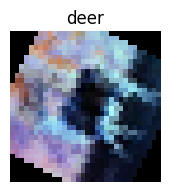

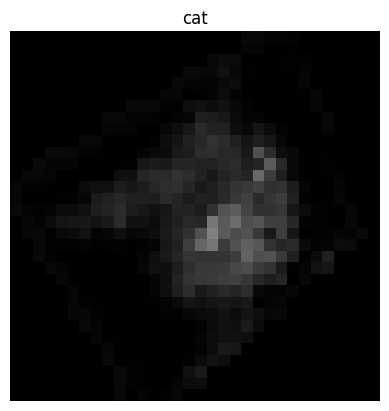

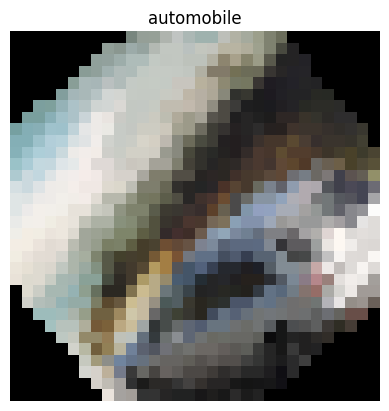

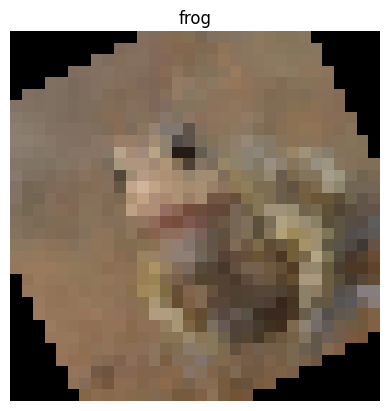

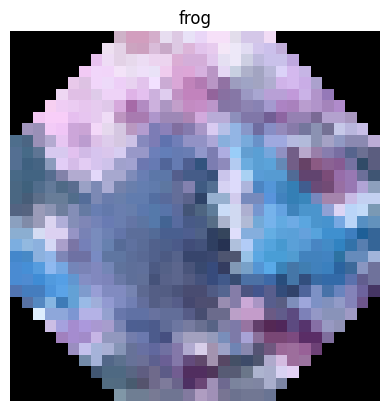

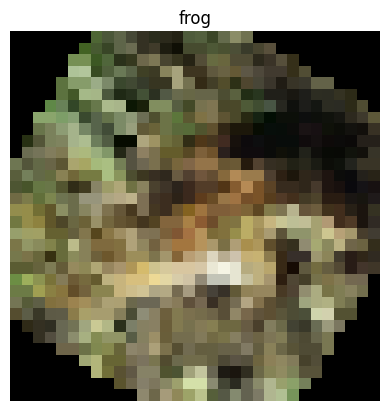

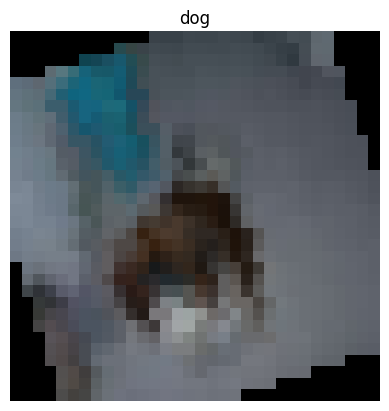

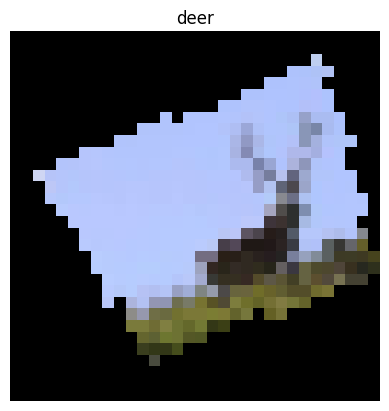

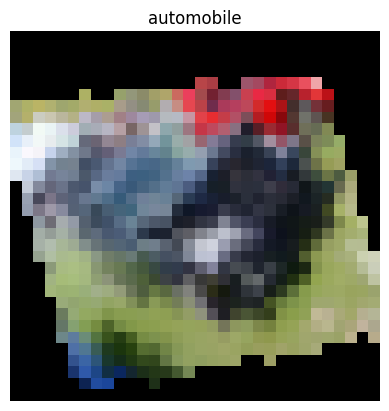

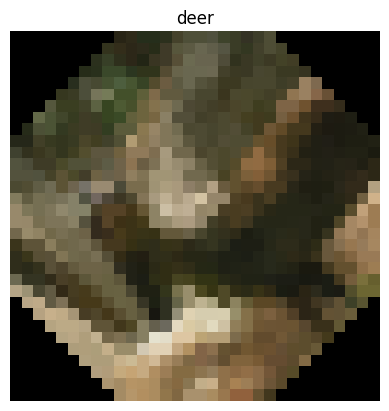

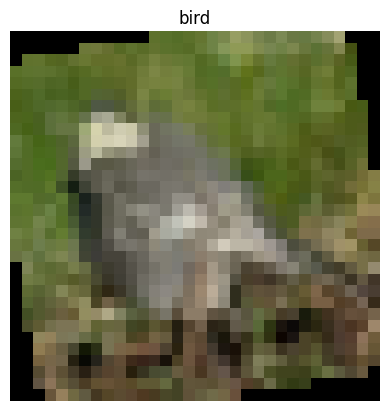

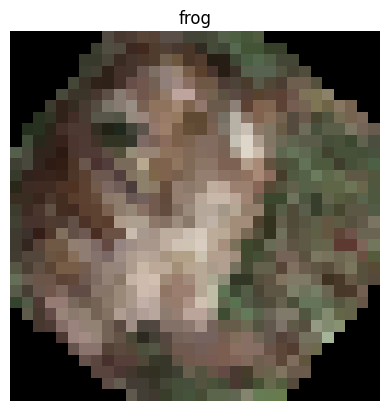

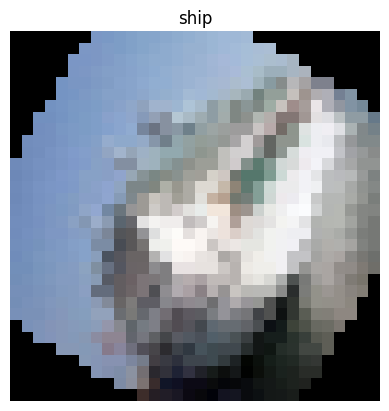

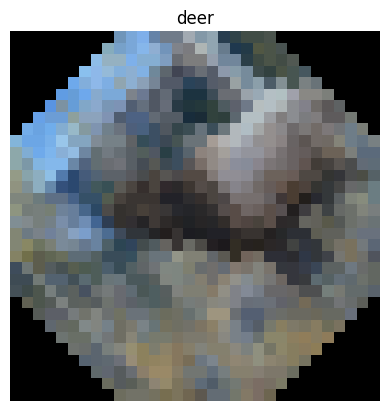

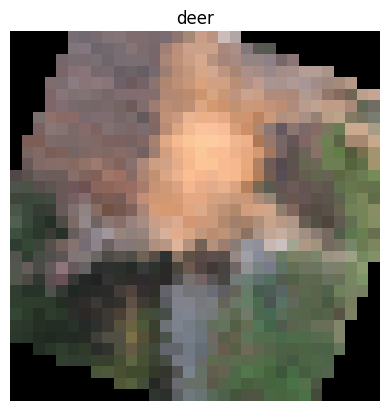

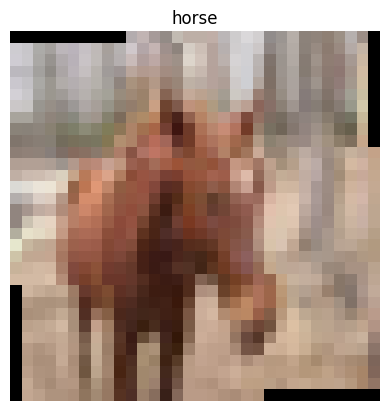

In [9]:
# Visualize first image
# image shape is [3, 64, 64] (colour channels, height, width)

fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze().permute(1, 2, 0))
    plt.title(class_names[label])
    plt.axis(False)
    plt.show()

In [10]:
# Set up batch size
BATCH_SIZE = 32

# Turn datasets into batches
train_dataloader = DataLoader(train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

test_dataloader = DataLoader(test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False)

print(f"Dataloaders: {train_dataloader, test_dataloader}")
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x7ade2e8e8d90>, <torch.utils.data.dataloader.DataLoader object at 0x7ade2e8e8e50>)
Length of train dataloader: 1563 batches of 32
Length of test dataloader: 313 batches of 32


In [11]:
# Check out what is inside the training dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 3, 32, 32]), torch.Size([32]))

Image size: torch.Size([3, 32, 32])
Label: 9, label size: torch.Size([])


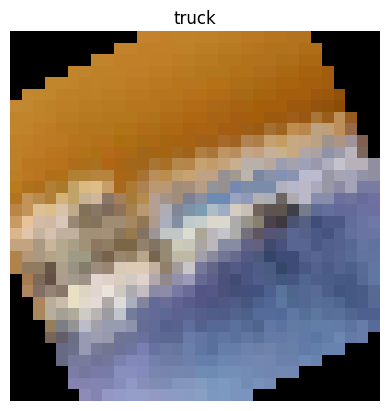

In [12]:
# Show a sample
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(img.squeeze().permute(1, 2, 0))
plt.title(class_names[label])
plt.axis("Off");
print(f"Image size: {img.shape}")
print(f"Label: {label}, label size: {label.shape}")
plt.show()

## Creating a base CNN model for testing - Model 0

In [13]:
# Build Model 0


class CIFAR10ModelV0(nn.Module):
    def __init__(self,
                 input_shape: int,
                 hidden_units: int,
                 output_shape: int):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=2,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=2,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 2, 1, 0),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 2, 1, 0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
            )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units * 36,
                      out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        return self.classifier(self.conv_block_2(self.conv_block_1(x)))

In [14]:
# Set up model with input parameters
model_0 = CIFAR10ModelV0(input_shape=3, # RBG
    hidden_units=10, # how many units in the hiden layer
    output_shape=len(class_names) # one for every class
).to(device)

model_0

CIFAR10ModelV0(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(2, 2), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(2, 2), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(2, 2), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(2, 2), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=360, out_features=10, bias=True)
  )
)

In [15]:
# Set up loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.01)

Functions are adapted from: https://github.com/mrdbourke/pytorch-deep-learning.git

In [16]:
# Making a accuracy function


def accuracy_fn(y_true, y_pred):
    """
    Calculates accuracy between truth labels and predictions.

    Args:
        y_true (torch.Tensor): Truth labels for predictions.
        y_pred (torch.Tensor): Predictions to be compared to predictions.

    Returns:
        [torch.float]: Accuracy value between y_true and y_pred, e.g. 78.45
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc


In [17]:
from timeit import default_timer as timer
def print_train_time(start: float, end: float, device: torch.device = None):
    """
    Returns difference between the start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format).
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on.
        Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

In [64]:
# Define train and test steps


def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    train_loss, train_acc = 0, 0
    model.to(device)
    for batch, (X, y) in enumerate(data_loader):
        # Send data to GPU
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1)) # Go from logits -> pred labels

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")


def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode():
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred = model(X)

            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y,
                y_pred=test_pred.argmax(dim=1) # Go from logits -> pred labels
            )

        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

In [19]:
# Measure time
from tqdm.auto import tqdm
from timeit import default_timer as timer
train_time_start_on_gpu = timer()

epochs = 10
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n{50 * '-'}")
    train_step(data_loader=train_dataloader,
        model=model_0,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn
    )
    test_step(data_loader=test_dataloader,
        model=model_0,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn
    )

train_time_end_on_gpu = timer()
total_train_time_model_0 = print_train_time(start=train_time_start_on_gpu,
                                            end=train_time_end_on_gpu,
                                            device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
--------------------------------------------------
Train loss: 2.30230 | Train accuracy: 10.64%
Test loss: 2.30008 | Test accuracy: 12.06%

Epoch: 1
--------------------------------------------------
Train loss: 2.29628 | Train accuracy: 13.63%
Test loss: 2.27051 | Test accuracy: 18.59%

Epoch: 2
--------------------------------------------------
Train loss: 2.24592 | Train accuracy: 18.86%
Test loss: 2.10494 | Test accuracy: 25.70%

Epoch: 3
--------------------------------------------------
Train loss: 2.19171 | Train accuracy: 22.54%
Test loss: 2.01554 | Test accuracy: 30.09%

Epoch: 4
--------------------------------------------------
Train loss: 2.08486 | Train accuracy: 26.42%
Test loss: 1.99911 | Test accuracy: 27.05%

Epoch: 5
--------------------------------------------------
Train loss: 2.01210 | Train accuracy: 28.76%
Test loss: 1.93513 | Test accuracy: 31.06%

Epoch: 6
--------------------------------------------------
Train loss: 1.96485 | Train accuracy: 30.45%
T

### CNN Model 0 performed poorly, trying a different approach.
Implementing Model 1 by changing optimizer to `torch.optim.Adam()` and learning rate to 0.1.

In [20]:
# Model 1


class CIFAR10ModelV1(nn.Module):
    def __init__(self,
                 input_shape: int,
                 hidden_units: int,
                 output_shape: int):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=2,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=2,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 2, 1, 0),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 2, 1, 0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
            )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units * 36,
                      out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        return self.classifier((self.conv_block_2(self.conv_block_1(x))))

In [21]:
# Set up model with input parameters
model_1 = CIFAR10ModelV1(input_shape=3, # RGB
    hidden_units=10, # how many units in the hiden layer
    output_shape=len(class_names) # one for every class
).to(device)

model_1

CIFAR10ModelV1(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(2, 2), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(2, 2), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(2, 2), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(2, 2), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=360, out_features=10, bias=True)
  )
)

In [22]:
# See model 1 summary
summary(model=model_1,
        input_size=(32, 3, 32, 32),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
CIFAR10ModelV1 (CIFAR10ModelV1)          [32, 3, 32, 32]      [32, 10]             --                   True
├─Sequential (conv_block_1)              [32, 3, 32, 32]      [32, 10, 15, 15]     --                   True
│    └─Conv2d (0)                        [32, 3, 32, 32]      [32, 10, 31, 31]     130                  True
│    └─ReLU (1)                          [32, 10, 31, 31]     [32, 10, 31, 31]     --                   --
│    └─Conv2d (2)                        [32, 10, 31, 31]     [32, 10, 30, 30]     410                  True
│    └─ReLU (3)                          [32, 10, 30, 30]     [32, 10, 30, 30]     --                   --
│    └─MaxPool2d (4)                     [32, 10, 30, 30]     [32, 10, 15, 15]     --                   --
├─Sequential (conv_block_2)              [32, 10, 15, 15]     [32, 10, 6, 6]       --                   True
│    └─Conv2d (0)   

In [23]:
loss_fn_m1 = nn.CrossEntropyLoss()
optimizer_m1 = torch.optim.Adam(params=model_1.parameters(), lr=0.1)

In [24]:
# Measure time
from tqdm.auto import tqdm
from timeit import default_timer as timer
train_time_start_on_gpu = timer()

epochs = 10
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n{30 * '-'}")
    train_step(data_loader=train_dataloader,
        model=model_1,
        loss_fn=loss_fn_m1,
        optimizer=optimizer_m1,
        accuracy_fn=accuracy_fn
    )
    test_step(data_loader=test_dataloader,
        model=model_1,
        loss_fn=loss_fn_m1,
        accuracy_fn=accuracy_fn
    )

train_time_end_on_gpu = timer()
total_train_time_model_1 = print_train_time(start=train_time_start_on_gpu,
                                            end=train_time_end_on_gpu,
                                            device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
------------------------------
Train loss: 2.37365 | Train accuracy: 10.26%
Test loss: 2.32833 | Test accuracy: 10.01%

Epoch: 1
------------------------------
Train loss: 2.31614 | Train accuracy: 9.69%
Test loss: 2.30846 | Test accuracy: 10.01%

Epoch: 2
------------------------------
Train loss: 2.31452 | Train accuracy: 9.76%
Test loss: 2.32045 | Test accuracy: 9.99%

Epoch: 3
------------------------------
Train loss: 2.31538 | Train accuracy: 10.09%
Test loss: 2.31274 | Test accuracy: 10.01%

Epoch: 4
------------------------------
Train loss: 2.31559 | Train accuracy: 10.12%
Test loss: 2.32731 | Test accuracy: 9.99%

Epoch: 5
------------------------------
Train loss: 2.31593 | Train accuracy: 9.68%
Test loss: 2.31385 | Test accuracy: 9.99%

Epoch: 6
------------------------------
Train loss: 2.31497 | Train accuracy: 10.06%
Test loss: 2.31593 | Test accuracy: 10.00%

Epoch: 7
------------------------------
Train loss: 2.31550 | Train accuracy: 10.07%
Test loss: 2.31811

## Trying transfer learning
Using MobileNet_V3_Large architecture from [Searching for MobileNetV3](https://arxiv.org/abs/1905.02244).
See documentation: https://pytorch.org/vision/main/models/generated/torchvision.models.mobilenet_v3_large.html#torchvision.models.MobileNet_V3_Large_Weights

In [25]:
# Construct weights
weights = torchvision.models.MobileNet_V3_Large_Weights.DEFAULT
weights

MobileNet_V3_Large_Weights.IMAGENET1K_V2

In [26]:
# get automatic transforms
mobile_transforms = weights.transforms()
mobile_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [66]:
# Set up batch size - increased from 32 to 64
BATCH_SIZE = 32

# set up data - wuth new transforms
train_data = CIFAR10(root="data",
                     download=True,
                     train=True,
                     transform=transforms.Compose([
                          transforms.ToTensor(),
                          mobile_transforms]))

test_data = CIFAR10(root="data",
                    download=True,
                    train=False,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        mobile_transforms]))


# Set up DataLoaders
train_dataloader = DataLoader(train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

test_dataloader = DataLoader(test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [67]:
model_2 = torchvision.models.mobilenet_v3_large(weights=weights).to(device)

summary(model=model_2,
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
MobileNetV3 (MobileNetV3)                                    [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 960, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 16, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 16, 112, 112]   432                  True
│    │    └─BatchNorm2d (1)                                  [32, 16, 112, 112]   [32, 16, 112, 112]   32                   True
│    │    └─Hardswish (2)                                    [32, 16, 112, 112]   [32, 16, 112, 112]   --                   --
│    └─InvertedResidual (1)                                  [32, 16, 112, 112]   [32, 16, 112

In [68]:
# Freeze all base layers
for param in model_2.parameters():
    param.requires_grad = False

In [69]:
# Recreate the classifier layer and seed it to the target device
model_2.classifier = torch.nn.Sequential(
    torch.nn.Linear(in_features=960,
                    out_features=len(class_names),
                    bias=True)).to(device)

In [70]:
summary(model=model_2,
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
MobileNetV3 (MobileNetV3)                                    [32, 3, 224, 224]    [32, 10]             --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 960, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 16, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 16, 112, 112]   (432)                False
│    │    └─BatchNorm2d (1)                                  [32, 16, 112, 112]   [32, 16, 112, 112]   (32)                 False
│    │    └─Hardswish (2)                                    [32, 16, 112, 112]   [32, 16, 112, 112]   --                   --
│    └─InvertedResidual (1)                                  [32, 16, 112, 112]   [32, 

In [71]:
# Define loss function and optimizer (back to SGD)
loss_fn_m2 = torch.nn.CrossEntropyLoss()
optimizer_m2 = torch.optim.SGD(model_2.parameters(), lr=0.1)

In [72]:
# Measure time
from tqdm.auto import tqdm
from timeit import default_timer as timer
train_time_start_on_gpu = timer()

epochs = 10
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n{30 * '-'}")
    train_step(data_loader=train_dataloader,
        model=model_2,
        loss_fn=loss_fn_m2,
        optimizer=optimizer_m2,
        accuracy_fn=accuracy_fn
    )
    test_step(data_loader=test_dataloader,
        model=model_2,
        loss_fn=loss_fn_m2,
        accuracy_fn=accuracy_fn
    )

train_time_end_on_gpu = timer()
total_train_time_model_2 = print_train_time(start=train_time_start_on_gpu,
                                            end=train_time_end_on_gpu,
                                            device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
------------------------------
Train loss: 0.82803 | Train accuracy: 71.72%
Test loss: 0.66358 | Test accuracy: 76.92%

Epoch: 1
------------------------------
Train loss: 0.62730 | Train accuracy: 78.18%
Test loss: 0.64047 | Test accuracy: 77.78%

Epoch: 2
------------------------------
Train loss: 0.59198 | Train accuracy: 79.47%
Test loss: 0.62528 | Test accuracy: 78.15%

Epoch: 3
------------------------------
Train loss: 0.56948 | Train accuracy: 80.17%
Test loss: 0.62758 | Test accuracy: 78.23%

Epoch: 4
------------------------------
Train loss: 0.55593 | Train accuracy: 80.66%
Test loss: 0.61970 | Test accuracy: 78.27%

Epoch: 5
------------------------------
Train loss: 0.54733 | Train accuracy: 81.03%
Test loss: 0.62866 | Test accuracy: 78.08%

Epoch: 6
------------------------------
Train loss: 0.53832 | Train accuracy: 81.17%
Test loss: 0.62317 | Test accuracy: 78.12%

Epoch: 7
------------------------------
Train loss: 0.53253 | Train accuracy: 81.32%
Test loss: 0

## Saving Transfer Learning model

In [78]:
# Saving model
from pathlib import Path

# Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, # create parent directories if needed
                 exist_ok=True # if models directory already exists, don't error
)

# Create model save path
MODEL_NAME = "cifar10_ccn_transfer_learning_model.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_2.state_dict(), # only saving the state_dict() only saves the learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models/cifar10_ccn_transfer_learning_model.pth
